## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats.mstats import winsorize

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , LogisticRegression


#Interpretability 
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
from alibi.explainers import ALE, plot_ale


import warnings
warnings.filterwarnings('ignore')

c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

In [3]:
def data_prep_brest_cancer(df, features_name):
    #Calculate correlation
    m_corr = df[features_name].corr(method="spearman")
    #Symetrique on conserve la partie sup
    upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape),k=1).astype(np.bool))
    
    #Suppresion des colonnes avec corrélation supérieur à 0.85
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    
    #Drop des colonnes trop corrélées
    df_no_corr = df.drop(to_drop, axis=1)
    training_features = df_no_corr.columns[:-1]

    ############
    # RESAMPLE #
    ############

    #Stratégie de undersampling. On peut aussi Upsample
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(df_no_corr.iloc[:,:-1], df_no_corr.target)

    #Train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    #Step winsorize skew distribution 
    #Winsorize outliers
    for col in X_train.columns:
         
        X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    

    return(X_train_sc, X_test_sc, y_train, y_test, training_features, scaler)
    

In [5]:
#Load dataset breast cancer
data = load_breast_cancer()

breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

**On inverse les modalités de Y car on cherche à déterminer s'il s'agit d'un cancer**

Actuellement :
- y= 0 maligne
- y =1 bénin

In [6]:
# On inverse la modalité de référence
breast.target = 1- breast.target

#### 2) Recréer l'ensemble de la pipeline visant à générer un SVM non linéaire (RBF ou degree >1)



In [7]:
X_train_sc, X_test_sc, y_train, y_test, training_features, scaler = data_prep_brest_cancer(df=breast, features_name=features_name)

In [8]:
best_model = SVC(random_state=42, C=0.5, kernel='poly',degree=2)

In [9]:
best_model.fit(X_train_sc, y_train)

SVC(C=0.5, degree=2, kernel='poly', random_state=42)

#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

In [10]:
#Prédiction pour un individu
best_model.predict(X_test_sc[0].reshape(1,16))

array([0.])

#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

Ici, l'idée est de mobiliser vos connaissance du modèle de régression logistique et d'interpréter les effets des variables.

In [11]:
lgr = LogisticRegression( random_state=42)
lgr.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

L'intérêt de centrer et réduire les variables est de pouvoir comparer le poids de chaque variable entre elles  
et ainsi en déduire leurs apports relatifs.

Plus son coefficent est élevé plus la variable à un impact important et les coefficients sont comparables car exprimés dans la même échelle


In [12]:
#coefficients standardisés
beta = pd.DataFrame(np.abs(lgr.coef_[0]),index=training_features,columns=['abs(coef)'])
beta.sort_values(by='abs(coef)', ascending=False)

,abs(coef)
mean_radius,2.207610
radius_error,1.778004
worst_symmetry,1.547153
concave_points_error,1.080721
mean_texture,1.077402
worst_fractal_dimension,0.870386
symmetry_error,0.765907
worst_smoothness,0.689901
fractal_dimension_error,0.667154
mean_compactness,0.634817


In [22]:
# Classe de référence est bénin
lgr.classes_

# 0 benin
# 1 maligne

array([0., 1.])

### Examiner les effets relatifs

In [13]:
# Coéfficients avec les signes ordre des liaisons variables target
beta = pd.DataFrame(lgr.coef_[0],index=training_features,columns=['coef'])
beta.sort_values(by='coef', ascending=False)

,coef
mean_radius,2.207610
radius_error,1.778004
worst_symmetry,1.547153
concave_points_error,1.080721
mean_texture,1.077402
worst_fractal_dimension,0.870386
worst_smoothness,0.689901
mean_compactness,0.634817
texture_error,0.114788
mean_smoothness,0.079723


- Quand mean_radius augmente la probabilité que la tumeur soit maligne augmente 
- Plus une tumeur est grosse plus la chance d'avoir une tumeur augmente.

**worst_symmetry** nous indique à quel point les conteurs de la tumeur son irrégulière.  
Plus une tumeur sera non régulière plus il sera probable que ce soit une tumeur maligne. 

#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 

### Partial depence plot

In [14]:
df_interpret = pd.DataFrame(X_test_sc, columns = training_features)

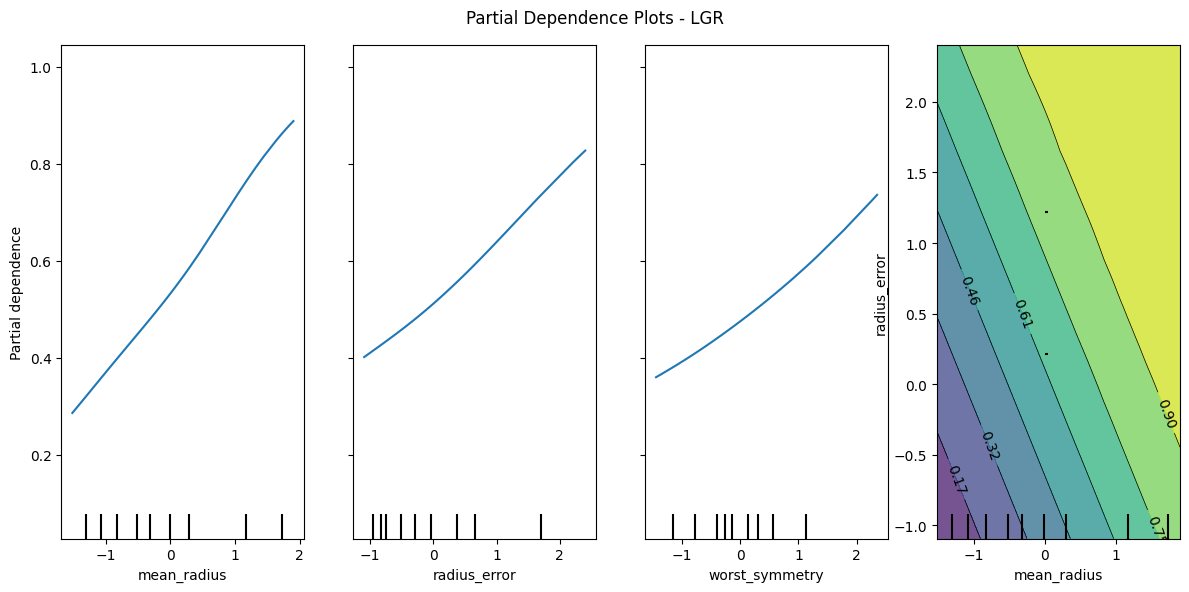

In [15]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["mean_radius","radius_error","worst_symmetry" ,('mean_radius','radius_error')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(lgr,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=4
                                         )
plt.suptitle("Partial Dependence Plots - LGR")
plt.tight_layout()
plt.show()

On retrouve bien des effets similaires à notre interprétation de la régression logistique.  
Quand mean_radius s'écarte de sa valeur moyenne en positif, cela induit une augmentation de chance d'avoir une tumeur maligne.

### Accumulated local effect

In [16]:
lgr_ale = ALE(lgr.predict, feature_names=training_features, target_names=["prob_cancer"])
lgr_exp = lgr_ale.explain(X_test_sc, min_bin_points=10)

array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='radius_error', ylabel='ALE'>]], dtype=object)

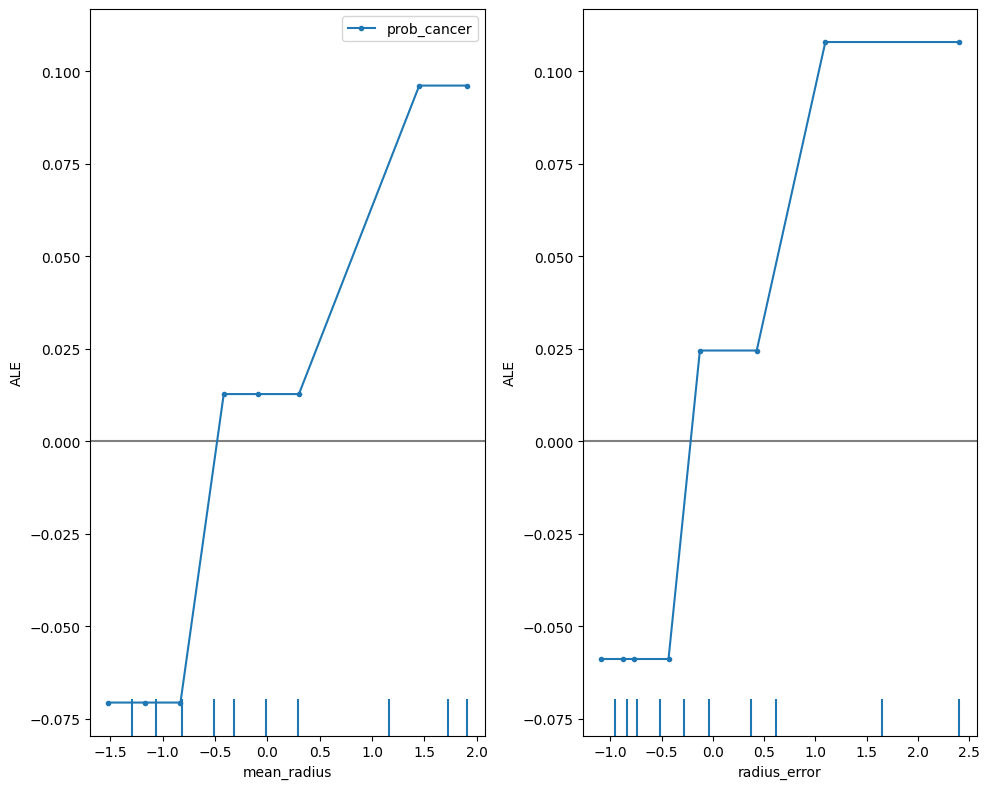

In [17]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(lgr_exp, features=["mean_radius","radius_error"], ax= ax1, targets=[0])

Le calcul des ALE offre un effet relativement similaire.  
:warning: Attention ici, il faut jouer sur le nombre de d'individus minimun par intervalle pour obtenir une interprétation correcte

Modifier la valeur de `min_bin_points` dans la fonction explainer



### Friedmann statistic

On souhaite étudier si l'interprétation de nos variables n'est pas fallacieuse et s'il n'y a pas d'effet joint caché.

In [39]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(lgr, pd.DataFrame(X_test_sc, columns=training_features), batchsize=100)

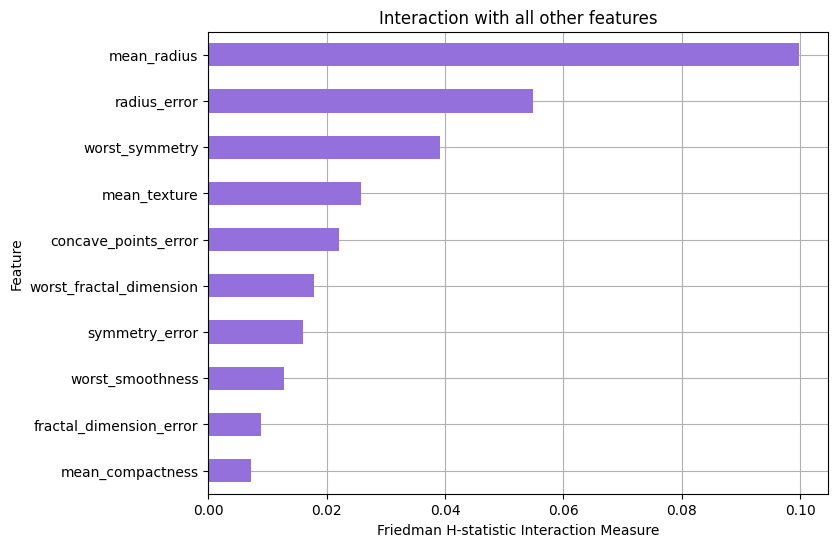

In [40]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart_ova",top_k=10 )

Les effets joints expliquent moins de 10% du pouvoir explicatif de nos variables.

## Permutation feature importance

In [41]:
result = permutation_importance(lgr, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring='accuracy'
                           )


In [42]:
pd.DataFrame(result.importances_mean, index=training_features, columns=['P-importance']).sort_values(by="P-importance", ascending=False)

,P-importance
mean_radius,0.169412
radius_error,0.086275
worst_symmetry,0.072941
concave_points_error,0.047843
mean_texture,0.036078
worst_smoothness,0.036078
worst_fractal_dimension,0.033725
mean_compactness,0.020392
symmetry_error,0.009412
mean_fractal_dimension,0.007843


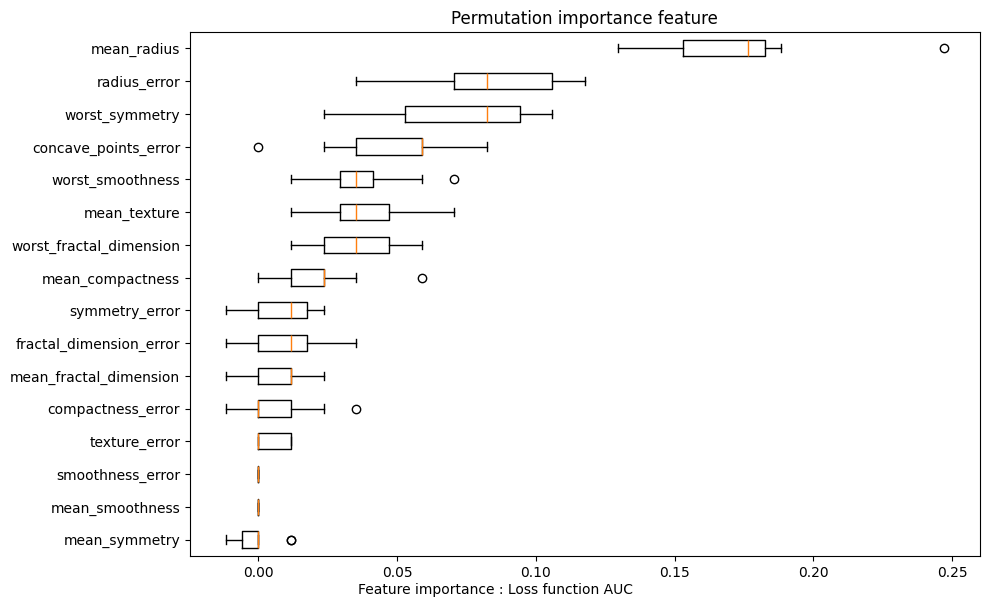

In [43]:
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=training_features[perm_sorted_idx]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')

fig.tight_layout()
plt.show()

Ici, la variable **mean_radius** diminue de 18% la valeur de l'AUC si on la retire du modèle.  
Cela semble en accord avec les résultats de la régression logistique

#### 6) Commenter et discuter des limites

- Interprétabilité complexe avec notre preprocessing et la standardisation
- Modèle agnostic en accord avec la régression linéaire. Une méthode externe offre les mêmes capacités d'interprétation que le modèle boite blanche
  

#### 7) Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales

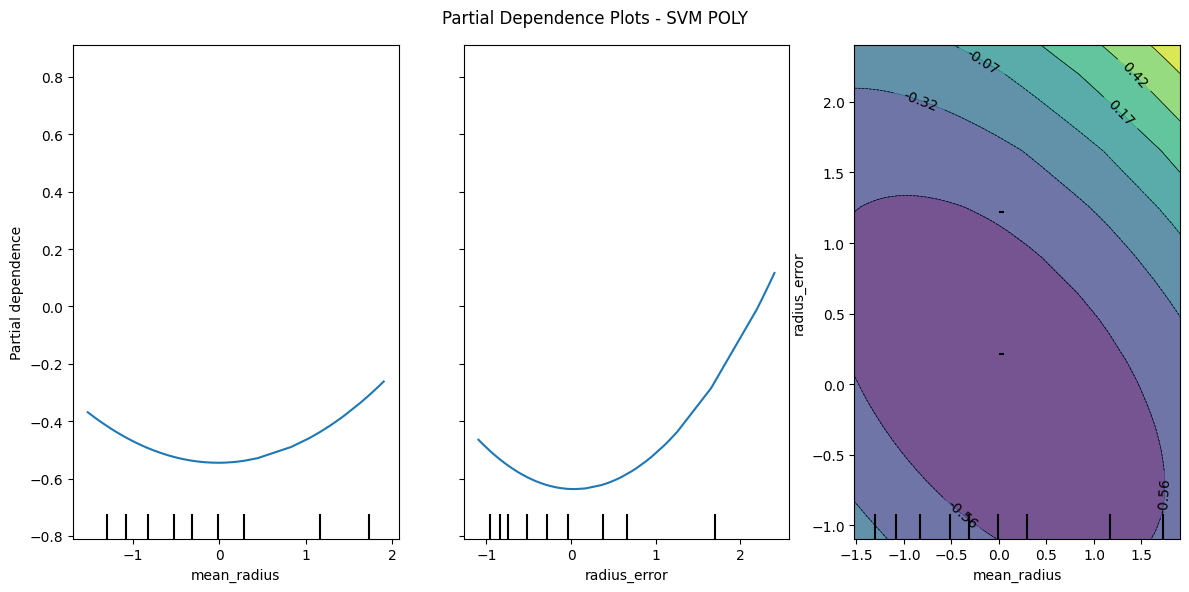

In [46]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["mean_radius","radius_error" ,('mean_radius','radius_error')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_model,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3
                                         )
plt.suptitle("Partial Dependence Plots - SVM POLY")
plt.tight_layout()
plt.show()

Les effets semblent plus nuancés que sur le modèle linéaire !!

Cette fois les intéractions entre nos variables et la target ne sont plus linéaires et non monotones.

On s'appuie sur le modèle qui offre le meilleur pouvoir prédictif pour valider la nature des relations entre nos variables explicatives et la target.

In [53]:
svm_ale = ALE(best_model.predict, feature_names=training_features, target_names=["prob_cancer"])
svm_exp = svm_ale.explain(X_test_sc, min_bin_points=10)

array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='mean_texture', ylabel='ALE'>]], dtype=object)

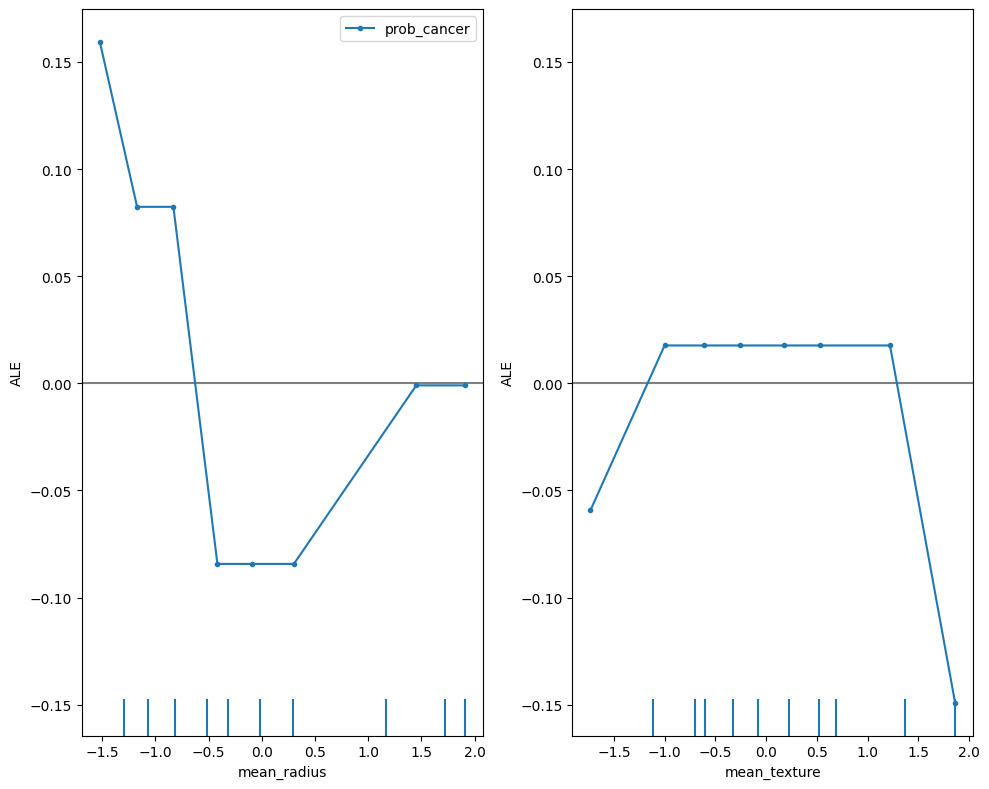

In [54]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(svm_exp, features=["mean_radius","mean_texture"], ax= ax1, targets=[0])

In [55]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(best_model, pd.DataFrame(X_test_sc, columns=training_features), batchsize=20)

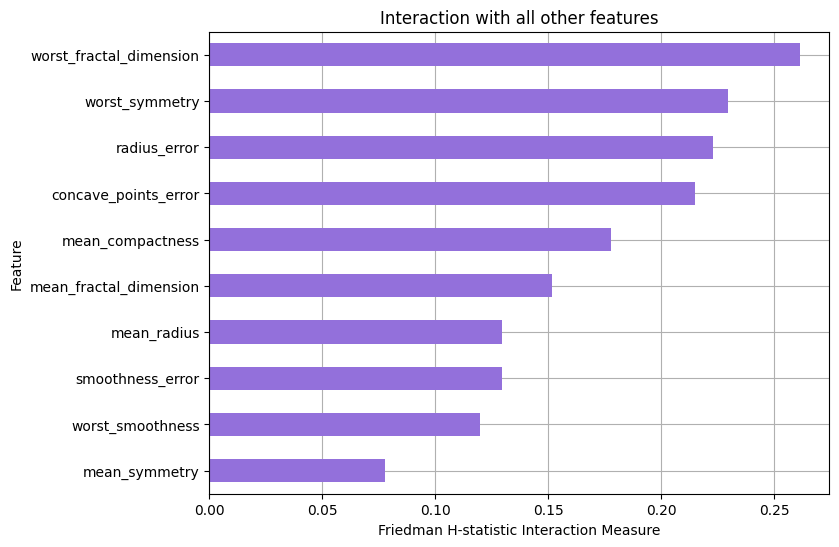

In [254]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart_ova",top_k=10 )
 

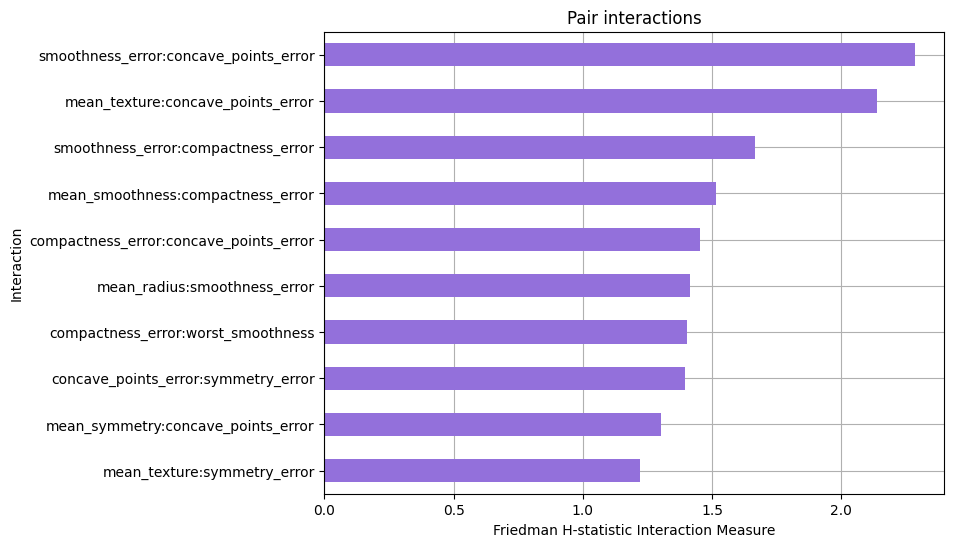

In [253]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart",top_k=10 )

## Permutation feature importance model non linéaire

In [56]:
result = permutation_importance(best_model, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring="accuracy"
                           )


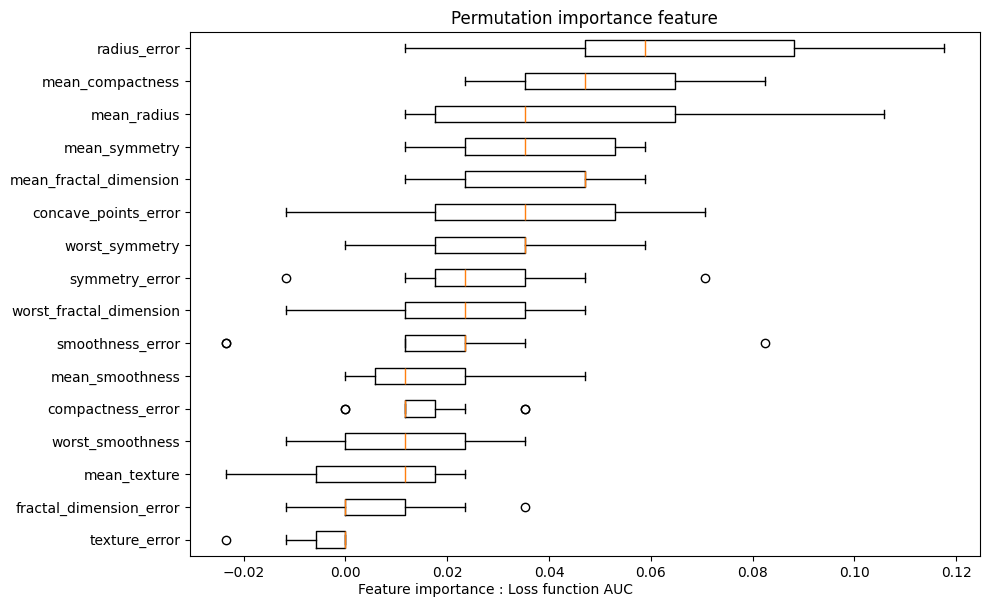

In [57]:
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=training_features[perm_sorted_idx]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')

fig.tight_layout()
plt.show()

La variable **mean_compactness** baisse la valeur de l'AUC de 7% en moyenne si on la retire du modèle

## Bonus, revenir aux valeurs d'origines des variables

Interpréter des données standardisées peut s'avérer relativement fastidieux voire impossible quand il s'agit de les présenter à des profils non techniques.

Il est donc possible de se ramener l'interprétation des PDP sur les données originelles

### Méthode N°1 : déstandardisation manuelle

Comme le standard scaler est formellement défini de la manière suivante :  
$z = \frac{x - \mu}{\sigma}$

Pour calculer son inverse, il faut simplement réaliser :  
$x = z \cdot \sigma + \mu$

In [19]:
analyse = pd.DataFrame(X_test_sc, columns=training_features)

In [20]:
# Calculer le PDP sur les données standardisées
num_col = 0
features_to_plot = [(num_col,)]  # Indices des colonnes à analyser
pdp_results = partial_dependence(
    lgr, analyse, features=features_to_plot, kind='average'
)

In [21]:
#Pdp_results possède 3 keys
pdp_results.keys()

# Grid_values = les valeurs des PDP
# values =  valeurs des données
# average = valeur moyenne par interval


dict_keys(['grid_values', 'values', 'average'])

Text(0.5, 1.0, 'Partial depence plot LGR')

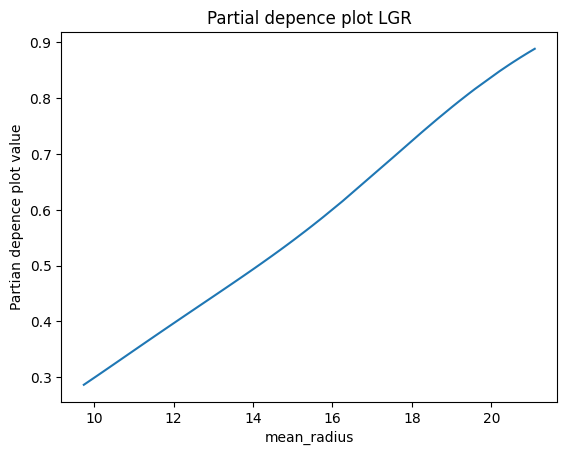

In [22]:
# Extraire les valeurs PDP (standardisées)
grid = pdp_results['values']  # Grille de valeurs pour chaque feature
pdp = pdp_results['average']  # Valeurs moyennes du PDP

# Appliquer l'inverse transformation sur la grille de valeurs
original_grid = [scaler.mean_[num_col] + grid[0] * scaler.scale_[num_col]]

plt.plot(original_grid[0],pdp[0])
plt.xlabel('mean_radius')
plt.ylabel('Partian depence plot value')
plt.title('Partial depence plot LGR')


### Méthode N°2 : Utiliser les sklearn pipelines

Comment les PDP sont issues des normes API de sklearn, on peut l'utiliser la notion de pipeline
pour se ramener aux données brutes en x-axis

In [23]:
# Train-test split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Classe pour Winsorisation
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        # Calculer les bornes sur le jeu d'entraînement uniquement
        self.lower_bounds_ = np.quantile(X, self.lower_quantile , axis=0)
        self.upper_bounds_ = np.quantile(X, self.upper_quantile, axis=0)
        return self

    def transform(self, X):
        # Appliquer la winsorisation
        return np.clip(X, self.lower_bounds_, self.upper_bounds_)

X_train, X_test, y_train, y_test = train_test_split(breast.iloc[:,:-1], breast.target, test_size=0.2, random_state=42, stratify=breast.target)


# Définir le pipeline
pipeline_lgr = Pipeline([
    ('winsorize', Winsorizer(lower_quantile=0.05, upper_quantile=0.95)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])

# Entraîner le pipeline
pipeline_lgr.fit(X_train, y_train)

Pipeline(steps=[('winsorize', Winsorizer()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=42))])

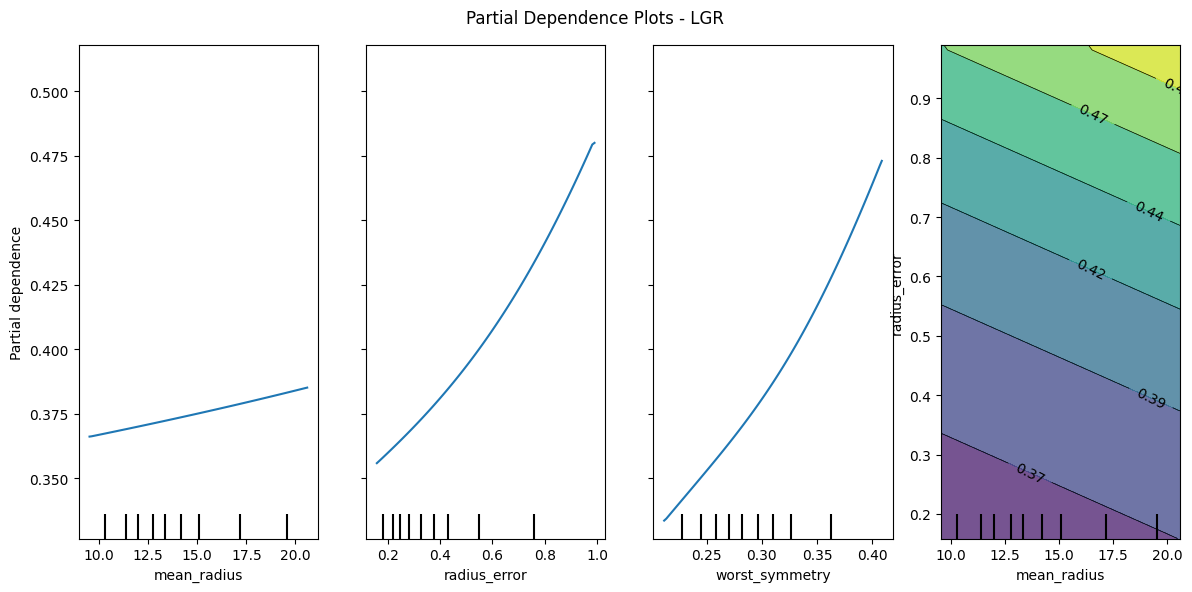

In [24]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["mean_radius","radius_error","worst_symmetry" ,('mean_radius','radius_error')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))

PartialDependenceDisplay.from_estimator( pipeline_lgr,  #votre modèle
                                         X_train, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=4
                                         )
plt.suptitle("Partial Dependence Plots - LGR")
plt.tight_layout()
plt.show()

:warning: Les résultats sont différents des premières PDP car je n'intègre pas le même dataset pour le calculer.
J'utilise un dataset avec toutes les données, mais si je supprime les corrélations dans ma pipepeline j'obtiendrai les mêmes résultas. :warning:

Dans le prochain TD nous verrons une méthode plus simple :)